In [31]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import os

import tensorflow as tf #딥러닝 인공지능 기법을 구현하기 쉽게 도와주는 라이브러리
from glob import glob #dataset 의 사진 파일을 list로 불러올 수 있게 도와주는 라이브러리
from tqdm import tqdm #반복문 진행률을 시각화해주는 라이브러리
from PIL import Image #이미지 분석 및 처리를 쉽게할 수 있게 도와주는 라이브러리

from sklearn.model_selection import train_test_split 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Conv2D, BatchNormalization, MaxPooling2D,Dropout, Flatten
from keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [32]:
#라벨들: 눈감음=0, 눈 뜸=1, 하품 함=2, 하품 안함=3

train_X=[]
train_Y=[]

#눈 감은 사진 사이즈 조절 및 numpy 객체로 만들기
for i in tqdm(glob('./archive/dataset_new/train/Closed/*')): #사진파일을 리스트로 불러옵니다.
    temp = Image.open(i).convert('L') #흑백으로 만듭니다.
    temp = np.array(temp.resize((64,64))) #64*64사이즈로 만든 뒤 numpy 배열 객체로 만듭니다.
    train_X.append(temp)
    train_Y.append(0) #눈 감은 사진의 라벨은 0입니다.
    
#눈 뜬 사진 사이즈 조절 및 numpy 객체로 만들기
for i in tqdm(glob('./archive/dataset_new/train/Open/*')): #사진파일을 리스트로 불러옵니다.
    temp = Image.open(i).convert('L') #흑백으로 만듭니다.
    temp = np.array(temp.resize((64,64))) #64*64사이즈로 만든 뒤 numpy 배열 객체로 만듭니다.
    train_X.append(temp)
    train_Y.append(1) #눈 뜬 사진의 라벨은 0입니다.
    
#하품 하는 사진 사이즈 조절 및 numpy 객체로 만들기
for i in tqdm(glob('./archive/dataset_new/train/yawn/*')): #사진파ㄴ일을 리스트로 불러옵니다.
    temp = Image.open(i).convert('L') #흑백으로 만듭니다.
    temp = np.array(temp.resize((64,64))) #64*64사이즈로 만든 뒤 numpy 배열 객체로 만듭니다.
    train_X.append(temp)
    train_Y.append(2) #하품 하는 사진의 라벨은 2입니다.
    
#하품 안하는 사진 사이즈 조절 및 numpy 객체로 만들기
for i in tqdm(glob('./archive/dataset_new/train/no_yawn/*')): #사진파일을 리스트로 불러옵니다.
    temp = Image.open(i).convert('L') #흑백으로 만듭니다.
    temp = np.array(temp.resize((64,64))) #64*64사이즈로 만든 뒤 numpy 배열 객체로 만듭니다.
    train_X.append(temp)
    train_Y.append(3) #하품 안하는 사진의 라벨은 3입니다.

100%|██████████| 616/616 [00:02<00:00, 245.10it/s]


In [33]:
train_X = (np.array(train_X) - np.min(train_X)) / (np.max(train_X)-np.min(train_X))
train_X = train_X / 255.0
train_Y = (np.array(train_Y) - np.min(train_Y)) / (np.max(train_Y) - np.min(train_Y))

print(train_X.shape) #2467, 64, 64
train_X = np.expand_dims(train_X, -1) #흑백데이터 1 추가
print(train_X.shape) #2467, 64, 64, 1

(2467, 64, 64)
(2467, 64, 64, 1)


In [34]:
print(train_Y.shape)

(2467,)


In [36]:
classes = 4

model = Sequential([
    Input(shape=[64,64,1]),
    
    #1번째 convolution - pooling 레이어 세트
      Conv2D(filters = 32, kernel_size = 5, strides = 1, activation = 'relu', use_bias=False),
      BatchNormalization(), #입력값을 평균 0, 분산 1로 정규화하여 학습이 잘 일어나도록 돕는 배치 정규화
      MaxPooling2D(strides = 2),
      Dropout(0.3),#과한 학습으로 인한 과적합을 줄이기 위하여 Dropout 실시

      #2번째 convolution - pooling 레이어 세트
      Conv2D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu', use_bias=False),
      BatchNormalization(),
      MaxPooling2D(strides = 2),
      Dropout(0.3),
      
      Flatten(), #1차원으로 변환
      # unit: 레이어에서 생성할 뉴런의 수, 출력차원을 결정하고 많을수록 표현력이 높아진다.
      # use_bias: 편향사용여부
      Dense(units  = 256, activation = 'relu', use_bias=False),
      BatchNormalization(),

      Dense(units = 128, use_bias=False, activation = 'relu'),

      Dense(units = 84, use_bias=False, activation = 'relu'),
      BatchNormalization(),
      Dropout(0.3),
      Dense(classes, activation = 'softmax')
])
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 60, 60, 32)        800       
                                                                 
 batch_normalization_24 (Bat  (None, 60, 60, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 30, 30, 32)       0         
 g2D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 30, 30, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 28, 28, 64)        18432     
                                                                 
 batch_normalization_25 (Bat  (None, 28, 28, 64)      

In [37]:
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy']) 
train_Y = to_categorical(train_Y, 4)

In [41]:
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='AdvancedModel.h5', #모델 저장 path 
    save_weights_only=False,#weight가 아닌 전체 모델을 저장
    monitor='val_loss', #손실이 체크포인트 저장 기준
    mode='min', #손실이 가장 낮은 모델을 저장
    verbose =1) #체크포인트 저장 시 로그 메세지 출력
#모델 정확도 증가 X == 저장 X
model.fit(train_X, train_Y, epochs=30, batch_size=32, callbacks=callback)

Epoch 1/30
77/78 [============================>.] - ETA: 0s - loss: 0.1380 - accuracy: 0.9489
Epoch 1: saving model to AdvancedModel.h5
78/78 [==============================] - 5s 66ms/step - loss: 0.1380 - accuracy: 0.9489
Epoch 2/30
77/78 [============================>.] - ETA: 0s - loss: 0.0595 - accuracy: 0.9789
Epoch 2: saving model to AdvancedModel.h5
78/78 [==============================] - 5s 69ms/step - loss: 0.0605 - accuracy: 0.9785
Epoch 3/30
77/78 [============================>.] - ETA: 0s - loss: 0.0543 - accuracy: 0.9801
Epoch 3: saving model to AdvancedModel.h5
78/78 [==============================] - 6s 76ms/step - loss: 0.0612 - accuracy: 0.9793
Epoch 4/30
77/78 [============================>.] - ETA: 0s - loss: 0.0376 - accuracy: 0.9858
Epoch 4: saving model to AdvancedModel.h5
78/78 [==============================] - 6s 71ms/step - loss: 0.0386 - accuracy: 0.9854
Epoch 5/30
77/78 [============================>.] - ETA: 0s - loss: 0.0330 - accuracy: 0.9878
Epoch 5: s

In [48]:
#라벨들: 눈감음=0, 눈 뜸=1, 하품 함=2, 하품 안함=3

test_X=[]
test_Y=[]

#눈 감은 사진 사이즈 조절 및 numpy 객체로 만들기
for i in tqdm(glob('./archive/dataset_new/test/Closed/*')): #사진파일을 리스트로 불러옵니다.
    temp = Image.open(i).convert('L') #흑백으로 만듭니다.
    temp = np.array(temp.resize((64,64))) #64*64사이즈로 만든 뒤 numpy 배열 객체로 만듭니다.
    test_X.append(temp)
    test_Y.append(0) #눈 감은 사진의 라벨은 0입니다.
    
#눈 뜬 사진 사이즈 조절 및 numpy 객체로 만들기
for i in tqdm(glob('./archive/dataset_new/test/Open/*')): #사진파일을 리스트로 불러옵니다.
    temp = Image.open(i).convert('L') #흑백으로 만듭니다.
    temp = np.array(temp.resize((64,64))) #64*64사이즈로 만든 뒤 numpy 배열 객체로 만듭니다.
    test_X.append(temp)
    test_Y.append(1) #눈 뜬 사진의 라벨은 1입니다.
    
#하품 하는 사진 사이즈 조절 및 numpy 객체로 만들기
for i in tqdm(glob('./archive/dataset_new/test/yawn/*')): #사진파ㄴ일을 리스트로 불러옵니다.
    temp = Image.open(i).convert('L') #흑백으로 만듭니다.
    temp = np.array(temp.resize((64,64))) #64*64사이즈로 만든 뒤 numpy 배열 객체로 만듭니다.
    test_X.append(temp)
    test_Y.append(2) #하품 하는 사진의 라벨은 2입니다.
    
#하품 안하는 사진 사이즈 조절 및 numpy 객체로 만들기
for i in tqdm(glob('./archive/dataset_new/test/no_yawn/*')): #사진파일을 리스트로 불러옵니다.
    temp = Image.open(i).convert('L') #흑백으로 만듭니다.
    temp = np.array(temp.resize((64,64))) #64*64사이즈로 만든 뒤 numpy 배열 객체로 만듭니다.
    test_X.append(temp)
    test_Y.append(3) #하품 안하는 사진의 라벨은 3입니다.
    
test_X = (np.array(test_X) - np.min(test_X)) / (np.max(test_X)-np.min(test_X))
test_X = test_X / 255.0
test_Y = (np.array(test_Y) - np.min(test_Y)) / (np.max(test_Y) - np.min(test_Y))

test_X = np.expand_dims(test_X, -1) #흑백데이터 1 추가
test_Y = to_categorical(test_Y, 4)

100%|██████████| 109/109 [00:00<00:00, 216.37it/s]


In [49]:
test_loss, test_acc = model.evaluate(test_X, test_Y)
print('Test Accuracy: ', test_acc, '\nTest Loss: ', test_loss)

14/14 [==============================] - 0s 16ms/step - loss: 0.0427 - accuracy: 0.9861
Test Accuracy:  0.986143171787262 
Test Loss:  0.04271558299660683


1/1 [==============================] - 0s 20ms/step


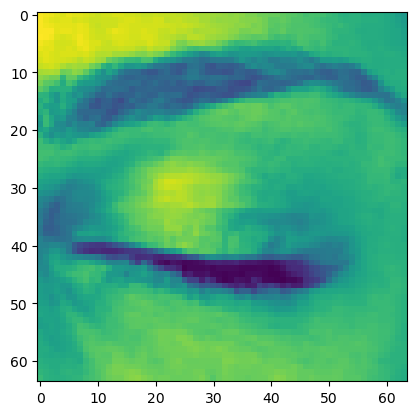

[[9.9999940e-01 1.3252568e-07 1.6321130e-07 3.0552837e-07]]
0
1/1 [==============================] - 0s 20ms/step


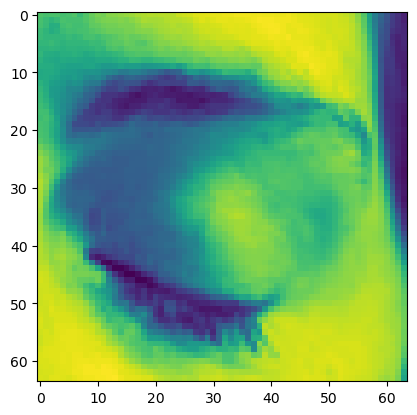

[[9.9999952e-01 2.7733302e-07 1.1256302e-07 1.6972051e-07]]
0
1/1 [==============================] - 0s 21ms/step


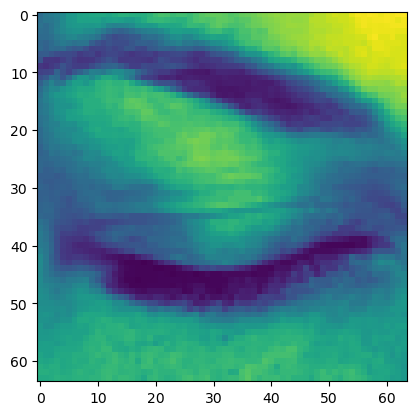

[[9.9999940e-01 7.3903891e-08 2.1391735e-07 2.3618770e-07]]
0
1/1 [==============================] - 0s 19ms/step


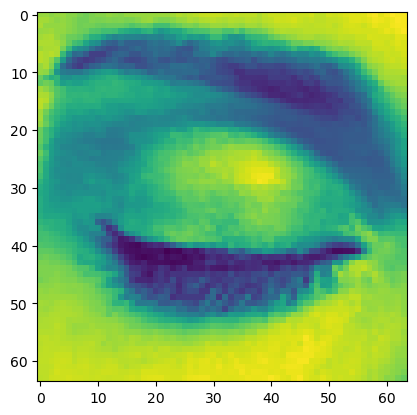

[[9.9999869e-01 1.1028460e-06 1.3299811e-07 1.4999412e-07]]
0
1/1 [==============================] - 0s 22ms/step


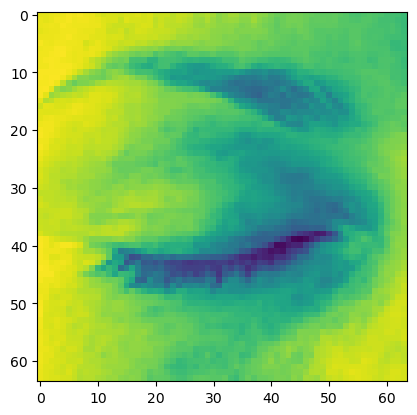

[[9.9999166e-01 8.2546603e-06 1.3865782e-07 5.1555350e-08]]
0
1/1 [==============================] - 0s 19ms/step


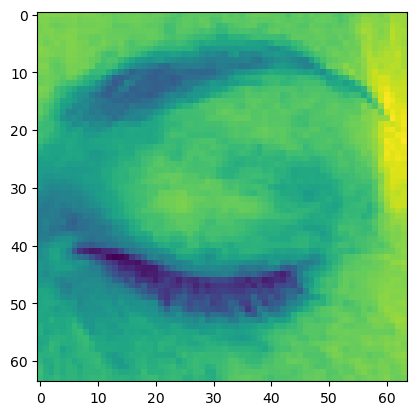

[[1.0000000e+00 8.7099781e-14 1.8308578e-10 4.0748016e-10]]
0
1/1 [==============================] - 0s 21ms/step


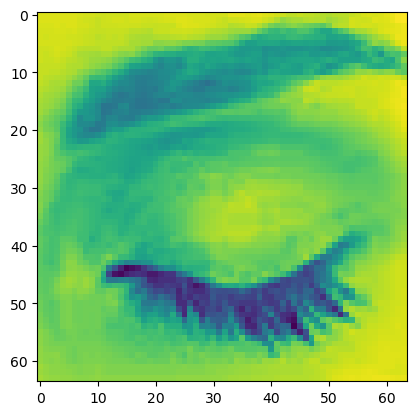

[[1.0000000e+00 1.5153484e-08 3.5111865e-09 4.9958304e-09]]
0
1/1 [==============================] - 0s 23ms/step


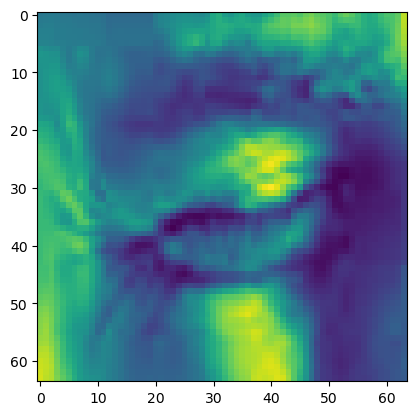

[[9.9999774e-01 1.6684271e-06 3.3321379e-07 2.3855654e-07]]
0
1/1 [==============================] - 0s 18ms/step


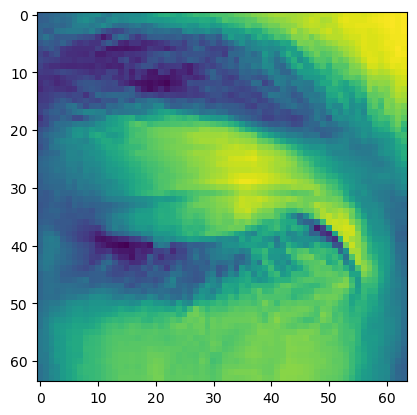

[[9.9997199e-01 1.9440622e-05 4.8761399e-06 3.7260547e-06]]
0
1/1 [==============================] - 0s 22ms/step


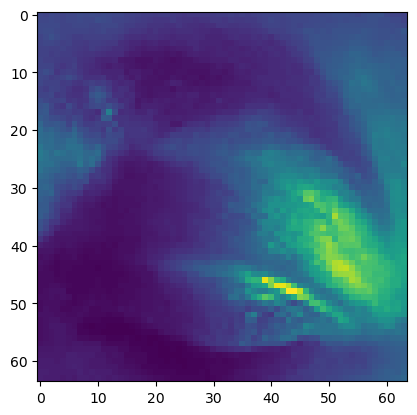

[[1.0000000e+00 7.0796523e-17 8.3200326e-14 2.6408097e-13]]
0


In [60]:
for img in test_X[0:10]:
    test_img = np.expand_dims(img, 0)
    prediction = model.predict(test_img)
    plt.imshow(img)
    plt.show()
    #print(prediction)
    print(np.argmax(prediction)) #가장 확률이 높은 클래스 출력